In [19]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

In [55]:
t1 = pd.read_csv('~/others_projects/mina/sheet1.csv')

In [56]:
t1.head(1)
print(len(t1))
t1.columns

609


Index(['Sr. #', ' Age/Sex', 'Presence of CAC', 'Hx of HTN', 'Comments', 'ACE',
       'ARB', 'BB', 'CCB', 'Others'],
      dtype='object')

In [57]:
t1['CAC'] = t1['Presence of CAC'].str.lower().str.strip()
t1['CAC'].unique()

array(['no', nan, 'yes'], dtype=object)

In [58]:
t1['Age'] = t1[' Age/Sex'].str.split(' ').str[0]
t1['Sex'] = t1[' Age/Sex'].str.split(' ').str[1]
print(len(t1[['Age', 'CAC']].dropna()))
#t1[]['Age'].astype(int)

608


Age     int64
CAC    object
dtype: object


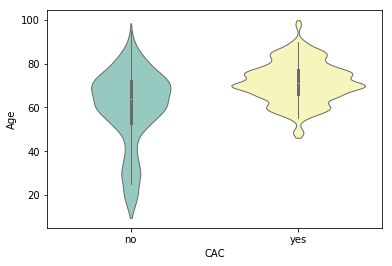

In [59]:
# Draw a violinplot with a narrower bandwidth than the default
cacAge = t1[['Age', 'CAC']].dropna()
cacAge['Age'] = cacAge['Age'].astype(int)
print(cacAge.dtypes)
cacAge
sns.violinplot(x='CAC', y='Age', data=cacAge, palette="Set3", bw=.2, cut=1, linewidth=1)